In [38]:
import datetime as dt
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from geopy import distance
from pandas.api.types import CategoricalDtype

In [39]:
# Create the day of week Category by iterrating over 7 days (March 4th, 2019 is a Monday)
days = [(dt.datetime(2019, 3, 4) + dt.timedelta(days=x)).strftime('%a') for x in range(0, 7)]
day_type = CategoricalDtype(categories=days, ordered=True)

# Create the month Category by iterrating over the months
months = [dt.datetime(2019, x, 1).strftime('%B') for x in range(1, 13)]
month_type = CategoricalDtype(categories=months, ordered=True)

In [40]:
df = pd.read_csv('./data/bikeshare_ridership.csv')

# Clean up column names for ease of use
df.columns = [' '.join(x.replace('trip_', '').replace('_seconds', '').split('_')).title() for x in df.columns]

In [41]:
df['Start Time'] = pd.to_datetime(df['Start Time'])
# df['Start Time'] = df['Start Time'].apply(lambda x: x - dt.timedelta(hours=4) if x.month < 7 else x)

df['Date'] = df['Start Time'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['Quarter'] = df['Start Time'].apply(lambda x: int((int(x.strftime('%m')) - 1) / 3) + 1)
df['Month'] = df['Start Time'].apply(lambda x: x.strftime('%B')).astype(month_type)
df['Day of Week'] = df['Start Time'].apply(lambda x: x.strftime('%a')).astype(day_type)
df['Hour'] = df['Start Time'].apply(lambda x: x.strftime('%H'))
# Create a "Route ID" in the "[start station ID]-[end station ID]" format
df['Route Id'] = df.apply(lambda x: '{0}-{1}'.format(int(x['Station Id From']), int(x['Station Id To'])), axis=1)

In [42]:
df_routes = df['Route Id'].value_counts(normalize=True) * 100
df_routes.head(50)

7059-7033    0.108626
7203-7076    0.106513
7076-7203    0.087612
7051-7042    0.064875
7171-7171    0.063430
7242-7222    0.063319
7016-7016    0.052200
7288-7288    0.051311
7171-7242    0.049532
7175-7175    0.048643
7242-7242    0.047364
7030-7033    0.046753
7242-7226    0.046641
7076-7075    0.046308
7220-7288    0.045919
7175-7171    0.045641
7222-7288    0.044974
7000-7033    0.044584
7288-7227    0.044251
7076-7076    0.044140
7203-7016    0.043695
7042-7051    0.043639
7049-7046    0.043417
7203-7043    0.042361
7033-7059    0.041638
7059-7118    0.041582
7288-7242    0.040526
7075-7076    0.040082
7171-7175    0.039748
7042-7008    0.039637
7242-7220    0.039359
7242-7288    0.039248
7220-7220    0.037858
7164-7028    0.037802
7027-7038    0.037524
7288-7222    0.037524
7033-7060    0.037302
7171-7076    0.036412
7222-7242    0.036135
7260-7282    0.036079
7021-7006    0.035634
7171-7226    0.034578
7038-7100    0.034522
7043-7203    0.033911
7175-7242    0.033688
7176-7033 

In [43]:
# Extract the unique routes from the data with their start and end coordinates
maps = df[['Route Id', 'Station Id From', 'Lat From', 'Lon From', 'Station Id To', 'Lat To', 'Lon To']].drop_duplicates()
maps['Distance'] = maps.apply(lambda x: distance.distance((x['Lat From'], x['Lon From']), (x['Lat To'], x['Lon To'])).km * 1000, axis=1)

In [44]:
maps.sample(10)

,Route Id,Station Id From,Lat From,Lon From,Station Id To,Lat To,Lon To,Distance
558007,7254-7057,7254,43.665461,-79.408480,7057,43.645857,-79.385365,2867.235636
1792400,7097-7339,7097,43.671172,-79.354704,7339,43.675319,-79.346279,820.925094
1748617,7054-7327,7054,43.640722,-79.391051,7327,43.674453,-79.434390,5125.151276
1261257,7251-7150,7251,43.668561,-79.394403,7150,43.655556,-79.433611,3477.000092
1296661,7069-7079,7069,43.649147,-79.395504,7079,43.660694,-79.379052,1845.892603
1292165,7329-7104,7329,43.645665,-79.415345,7104,43.657071,-79.356598,4905.879511
1785330,7331-7085,7331,43.695950,-79.328535,7085,43.687323,-79.304848,2136.711092
1766642,7050-7359,7050,43.652634,-79.374222,7359,43.682645,-79.377557,3345.225993
1364348,7132-7208,7132,43.670318,-79.405181,7208,43.656296,-79.414663,1735.525667
1683614,7167-7373,7167,43.654444,-79.371111,7373,43.650955,-79.370700,389.085257


In [45]:
# Merge the distance calculation with the main DataFrame
df = df.merge(maps[['Route Id', 'Distance','Lat From','Lon From','Lat To','Lon To']], how='left', on='Route Id')
df = df[[x for x in df.columns if x != 'Route Id']]

In [46]:
df.sample(10)

,Id,Duration,Start Time,User Type,Station Id From,Name From,Lat From_x,Lon From_x,Station Id To,Name To,...,Date,Quarter,Month,Day of Week,Hour,Distance,Lat From_y,Lon From_y,Lat To_y,Lon To_y
1790889,2408198,566,2018-01-17 15:56:00,Annual Member,7093,Danforth Ave / Gough Ave,43.678401,-79.346289,7087,Danforth Ave / Aldridge Ave,...,2018-01-17,1,January,Wed,15,2483.045994,43.678401,-79.346289,43.684758,-79.316767
1095399,2523124,726,2018-03-07 09:50:00,Annual Member,7115,Howard St / Sherbourne St,43.671258,-79.376367,7132,Kendal Ave / Spadina Rd,...,2018-03-07,1,March,Wed,09,2326.147816,43.671258,-79.376367,43.670318,-79.405181
840146,3846250,982,2018-08-29 14:20:00,Annual Member,7025,Ted Rogers Way / Bloor St E,43.671293,-79.380471,7023,College St / Borden St,...,2018-08-29,3,August,Wed,14,2568.023157,43.671293,-79.380471,43.657100,-79.405600
1680522,3920231,1792,2018-09-05 15:22:00,Casual Member,7102,Nelson St / Duncan St,43.648711,-79.389728,7237,Ward Ave / Wallace Ave,...,2018-09-05,3,September,Wed,15,4784.937310,43.648711,-79.389728,43.662251,-79.446036
574255,2766815,918,2018-05-08 08:41:00,Annual Member,7129,Davenport Rd / Avenue Rd,43.674991,-79.396273,7015,King St W / Bay St (West Side),...,2018-05-08,2,May,Tue,08,3202.032743,43.674991,-79.396273,43.648520,-79.380576
714606,4532006,494,2018-12-13 19:29:00,Annual Member,7188,Exhibition GO (Atlantic Ave),43.636667,-79.419722,7197,Queen St W / Dovercourt Rd,...,2018-12-13,4,December,Thu,19,803.460326,43.636667,-79.419722,43.643611,-79.422500
613466,2834022,1254,2018-05-17 08:27:00,Annual Member,7051,Wellesley St E / Yonge St (Green P),43.665060,-79.383570,7049,Queen St W / Portland St,...,2018-05-17,2,May,Thu,08,2419.754964,43.665060,-79.383570,43.647600,-79.401500
937638,4054118,381,2018-09-19 07:48:00,Annual Member,7017,Widmer St / Adelaide St W,43.647508,-79.391484,7004,University Ave / Elm St,...,2018-09-19,3,September,Wed,07,1019.428067,43.647508,-79.391484,43.656518,-79.389099
887480,2656203,616,2018-04-18 13:51:00,Annual Member,7258,Queen St E / Larchmount Ave,43.662279,-79.334166,7099,Cherry St / Mill St,...,2018-04-18,2,April,Wed,13,2269.709082,43.662279,-79.334166,43.651248,-79.357848
417711,4101692,1001,2018-09-24 07:58:00,Annual Member,7096,Boston Ave / Queen St E,43.661508,-79.338931,7118,King St W / Bay St (East Side),...,2018-09-24,3,September,Mon,07,3614.315466,43.661508,-79.338931,43.648575,-79.380042


In [47]:
df.to_csv("./data/trips.csv")

In [ ]:
#New
census_df = pd.read_csv("./data/CT_2016.csv")
all_CT_gdf = geopandas.read_file("./data/lda_000b16a_e.shp")

In [10]:
# Set default visualization styles
sns.set_style('dark')

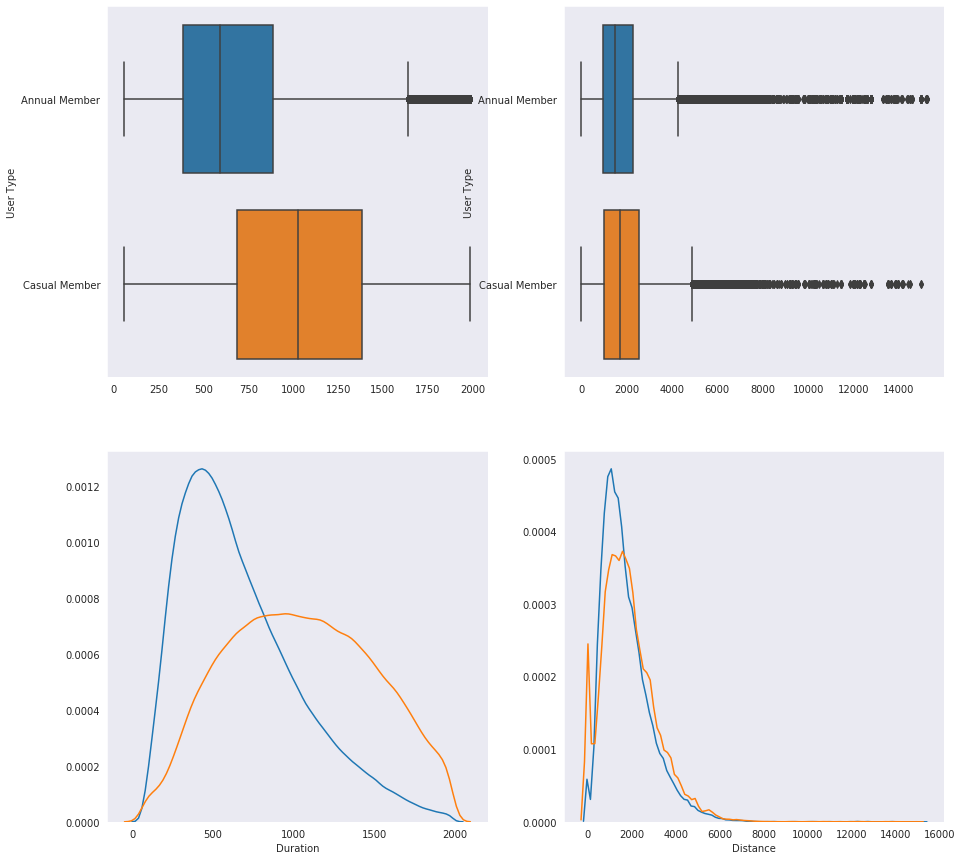

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(15, 15))

for i, col in enumerate(['Duration', 'Distance']):
    # Graph the distribution plots (seaborn doesn't allow default separation for distplot)
    for j, user in enumerate(df['User Type'].unique()):
        sns.distplot(df[df['User Type']==user][col], hist=False, ax=ax2[i])
    
    # Graph the boxplots
    sns.boxplot(x=col, y='User Type', data=df, ax=ax1[i])
    ax1[i].set_xlabel('')

plt.savefig('./visualization/distributions.png')

In [13]:
# Aggregate the ridership by date fields and user type and| count the number of unique trips
ridership = df.groupby(['Date', 'Quarter', 'Month', 'Day of Week', 'User Type'])['Id'].nunique().reset_index().sort_values('User Type', ascending=False)

In [14]:
ridership.sample(10)

,Date,Quarter,Month,Day of Week,User Type,Id
211573,2018-11-11,4,May,Wed,Casual Member,0
119864,2018-06-28,2,June,Sat,Annual Member,0
24897,2018-02-07,1,March,Wed,Casual Member,0
116407,2018-06-23,1,November,Sat,Casual Member,0
17007,2018-01-26,2,March,Sat,Casual Member,0
158535,2018-08-24,4,August,Sun,Casual Member,0
170042,2018-09-11,1,February,Sun,Annual Member,0
148903,2018-08-10,3,April,Sun,Casual Member,0
38933,2018-02-27,4,September,Sun,Casual Member,0
207569,2018-11-05,4,July,Wed,Casual Member,0


In [15]:
ridership = ridership[ridership.Id != 0]

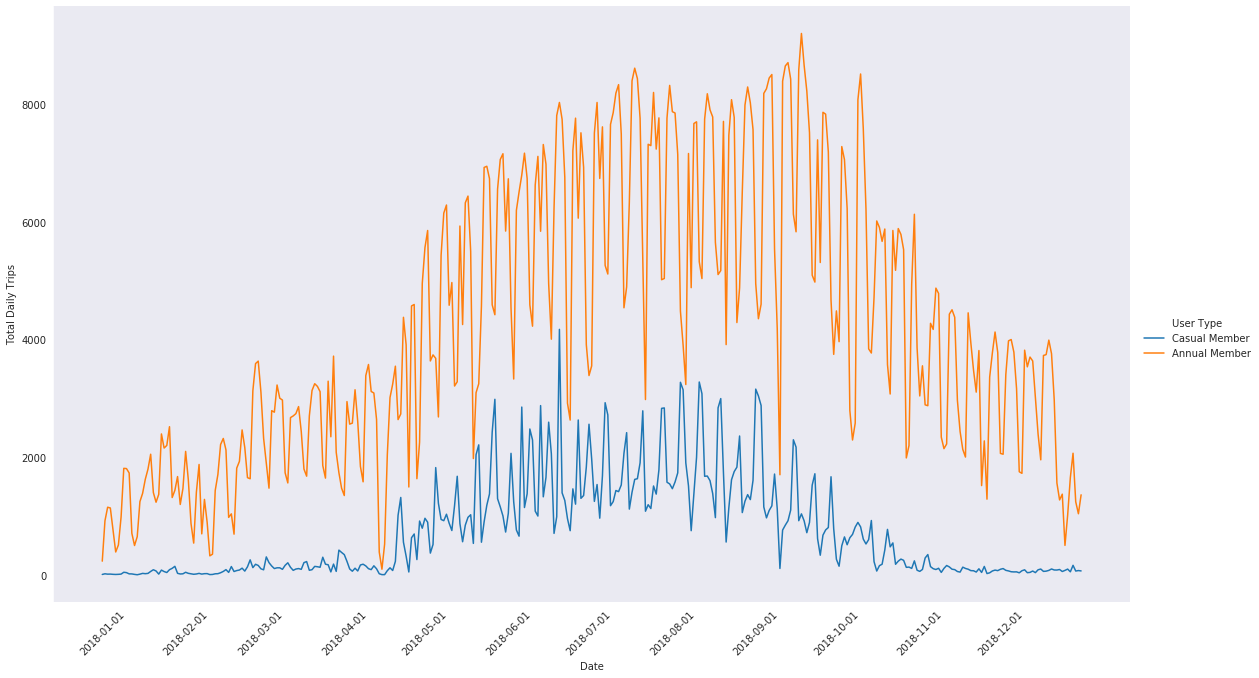

In [16]:
p = sns.relplot(x='Date', y='Id', hue='User Type', data=ridership, kind='line', height=9, aspect=16/9.)
p.ax.set_ylabel('Total Daily Trips')

# Limit the number of labels shown on the x-axis to only show the first day of each month
p.ax.set_xticklabels([x.set_text('') if not x.get_text().endswith('-01') else x for x in p.ax.get_xticklabels()], rotation=45)

plt.savefig('./visualization/ridership.png')

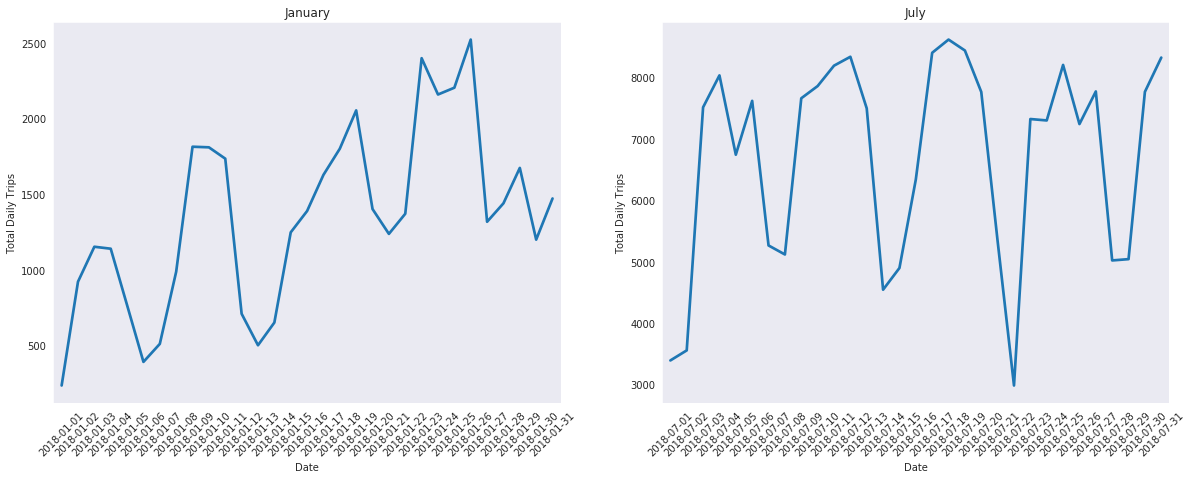

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for ax, m in zip(axes, ['January', 'July']):
    sns.pointplot(x='Date', y='Id', data=ridership[(ridership['Month']==m)&(ridership['User Type']=='Annual Member')].groupby('Date')['Id'].sum().reset_index(), ax=ax, markers='')
    
    ax.set_title(m)
    ax.set_ylabel('Total Daily Trips')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.savefig('./visualization/ridership_selection.png')

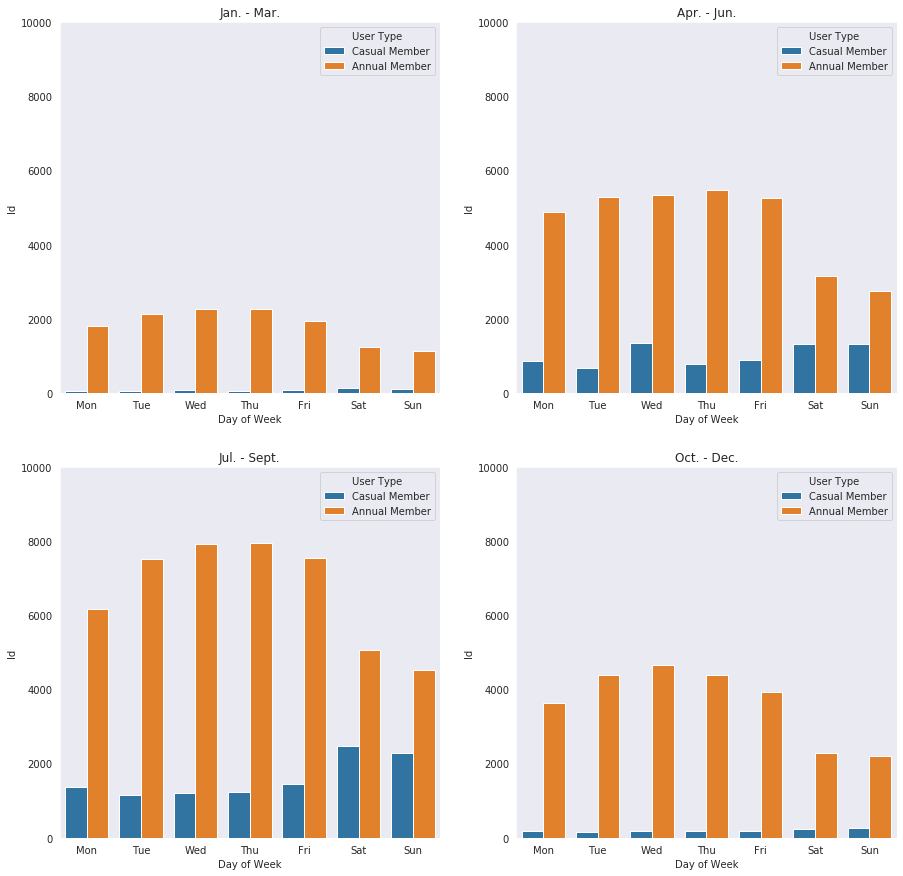

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = np.array(axes).flatten()                                               # Flatten the 2D axes array for ease of looping
quarter_names = ['Jan. - Mar.', 'Apr. - Jun.', 'Jul. - Sept.', 'Oct. - Dec.'] # Prepare the month description titles for each quarter

for q, ax in zip(sorted(ridership['Quarter'].unique()), axes):
    ax.set_title(quarter_names[(q-1)])
    
    # Set the y-axis range for consistency across the four graphs
    ax.set_ylim(0, 10000)
    ax.set_ylabel('Average Daily Trips')
    
    viz = ridership[ridership['Quarter']==q].groupby(['Day of Week', 'User Type'])['Id'].mean().reset_index().sort_values('User Type', ascending=False)
    
    sns.barplot(
        x='Day of Week', 
        y='Id', 
        hue='User Type', 
        data=viz, 
        ax=ax
    )

plt.savefig('./visualization/quarterly.png')

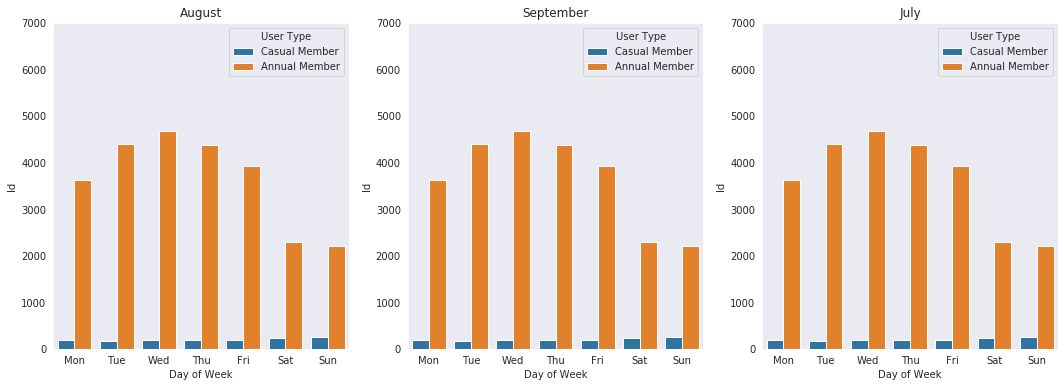

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = np.array(axes).flatten()

for m, ax in zip(ridership[ridership['Quarter']==3]['Month'].unique(), axes):
    ax.set_title(m)
    ax.set_ylim(0, 7000)
    ax.set_ylabel('Average Daily Trips')
    
    viz = ridership[ridership['Quarter']==q].groupby(['Day of Week', 'User Type'])['Id'].mean().reset_index().sort_values('User Type', ascending=False)

    
    sns.barplot(
        x='Day of Week', 
        y='Id', 
        hue='User Type', 
        data=viz, 
        ax=ax
    )
    
plt.savefig('./visualization/third_quarter.png')

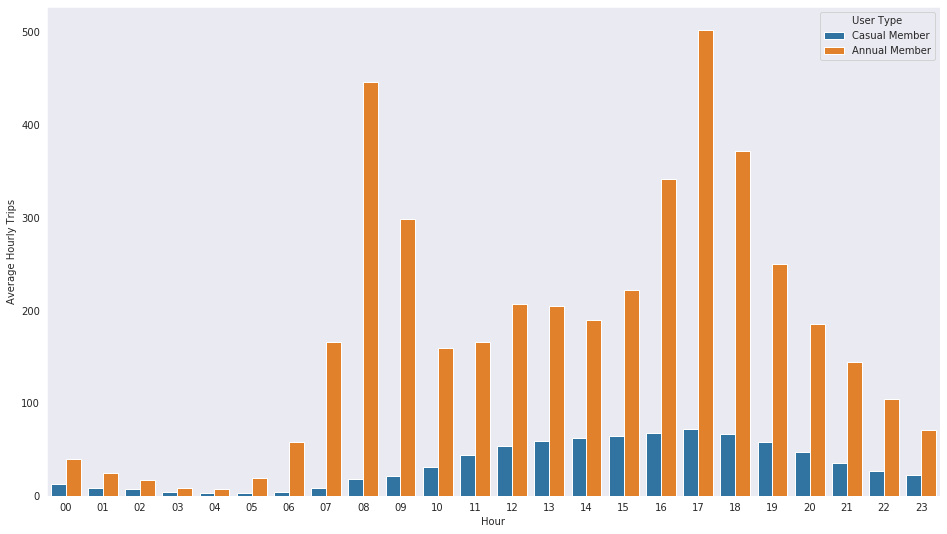

In [20]:
data = df.groupby(['Date', 'Hour', 'User Type'])['Id'].nunique().groupby(['Hour', 'User Type']).mean().reset_index().sort_values('User Type', ascending=False)

fig, ax = plt.subplots(figsize=(16, 9))

sns.barplot(x='Hour', y='Id', hue='User Type', data=data, ax=ax)
ax.set_ylabel('Average Hourly Trips')

plt.savefig('./visualization/hourly.png')

In [ ]:
# Import the weather data and drop the first 22 rows (containing descriptions of the weather station)
weather = pd.read_csv('./data/weather.csv', header=22)
# Remove units contained in the column names (eg. Celcius, mm, etc.)
weather.columns = [re.sub(r'\([^()]*\)', '', x).strip() if x != 'Date/Time' else 'Date' for x in weather.columns]

In [39]:
data = df.groupby(['Date', 'User Type'])['Id'].nunique().to_frame().pivot_table(index='Date', columns='User Type').reset_index()
data.columns = ['Date', 'Casual Trips', 'Member Trips']

data = data.merge(weather[['Date', 'Mean Temp', 'Total Precip']], on='Date', how='inner')

In [22]:
data.sample(10)

,Date,Casual Trips,Member Trips,Mean Temp,Total Precip
197,2017-07-17,1066,4645,22.5,0.0
348,2017-12-15,26,1620,-6.4,0.5
141,2017-05-22,984,1602,NaN,NaN
24,2017-01-25,72,1989,3.4,2.6
258,2017-09-16,2344,3998,21.6,0.0
289,2017-10-17,436,5991,11.7,0.0
33,2017-02-03,30,1477,-5.7,0.0
181,2017-07-01,1930,1966,21.2,3.2
183,2017-07-03,2333,2476,20.3,0.0
45,2017-02-15,10,1687,-1.1,0.0


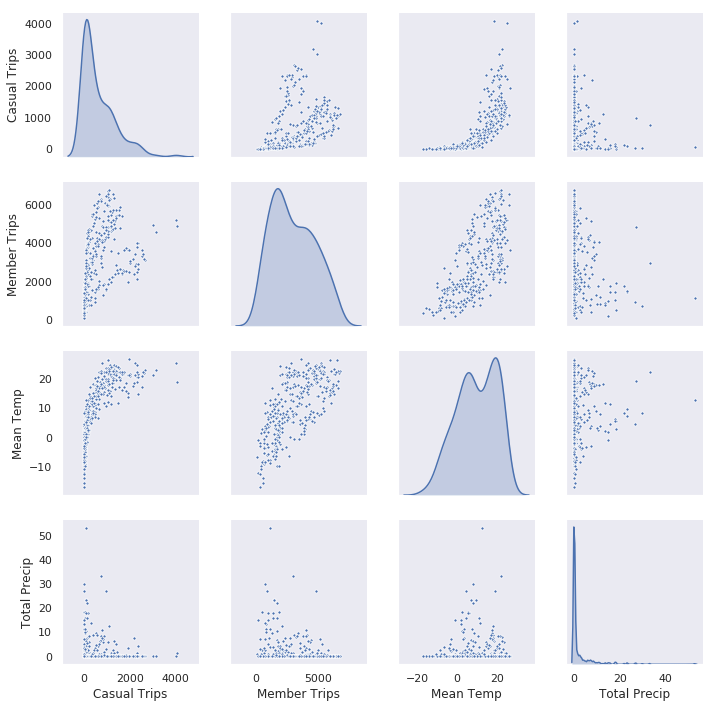

In [37]:
g = sns.pairplot(data, diag_kind='kde', plot_kws={'s': 10})
g.fig.set_size_inches(10, 10)

g.savefig('./visualization/pair.png')

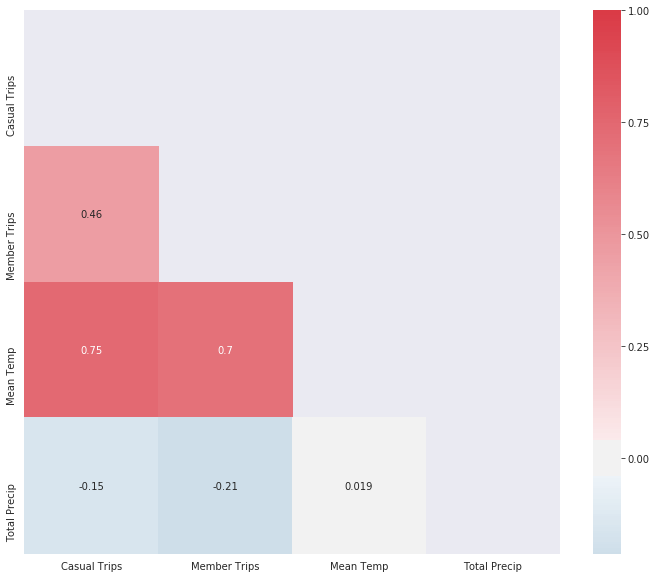

In [29]:
fig, ax = plt.subplots(figsize=(12, 10))

corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, cmap=sns.diverging_palette(240, 10, as_cmap=True), center=0)

plt.savefig('./visualization/heatmap.png')

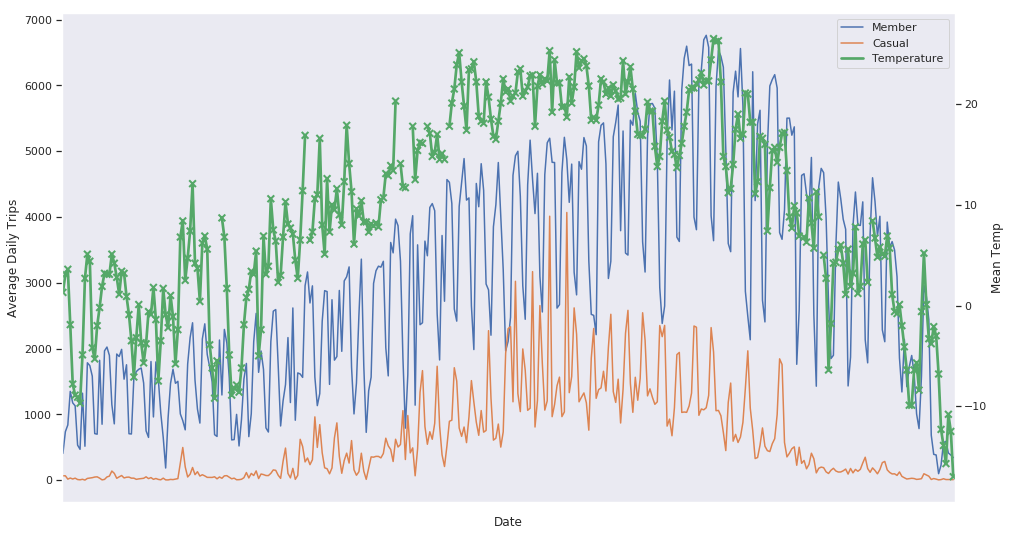

In [40]:
fig, ax = plt.subplots(figsize=(16, 9))
ax2 = ax.twinx()              # Create the twin axis to enable display of ridership and temperature on the same graph
palette = sns.color_palette() # Get the default color palette

for i, user_type in enumerate(['Member Trips', 'Casual Trips']):
    sns.lineplot(x='Date', y=user_type, data=data, ax=ax, color=palette[i], markers='')
    
sns.pointplot(x='Date', y='Mean Temp', data=data, ax=ax2, color=palette[2], markers='x')

ax.set_ylabel('Average Daily Trips')
ax.set_xticklabels([x.set_text('') if not x.get_text().endswith('-01') else x for x in ax.get_xticklabels()], rotation=45)

# Create the legend (due to the way this graph is created the default legend is not correct)
ax.legend(handles=ax.lines + ax2.lines, labels=['Annual', 'Casual', 'Temperature'])
plt.savefig('./visualization/temperature.png')

In [29]:
data = data.sort_values('Mean Temp').dropna().reset_index(drop=True)

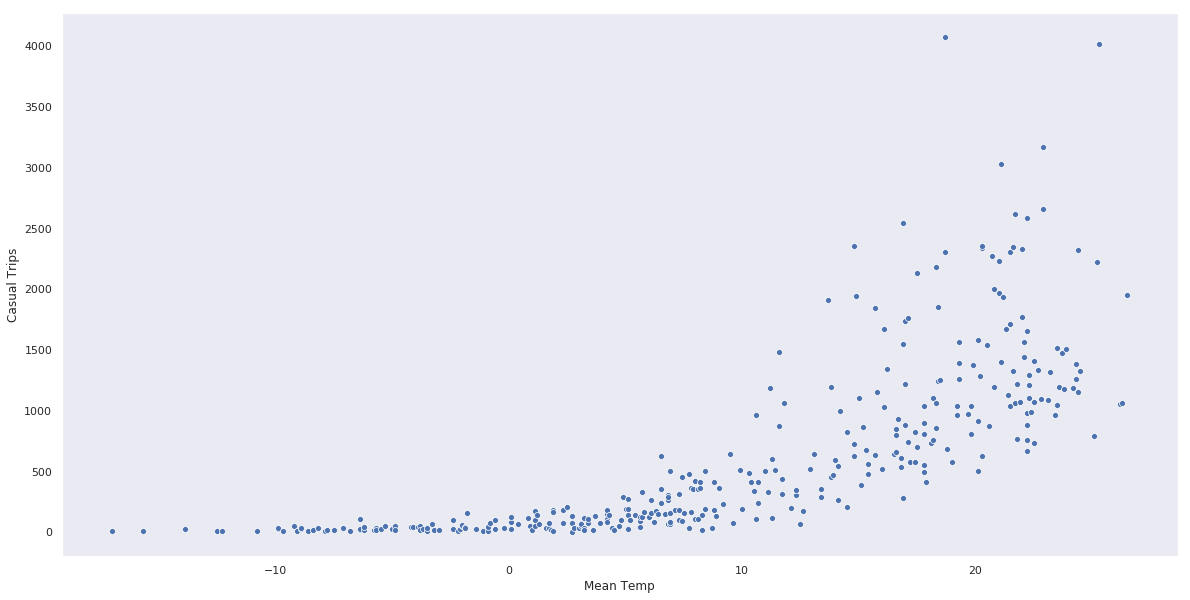

In [30]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.scatterplot(x='Mean Temp', y='Casual Trips', data=data)
plt.savefig('./visualization/fit_0.png')

In [31]:
from kneed import KneeLocator
from scipy.optimize import curve_fit

# Define the curve fitting equations
def linear(x, m, b):
    return m*x + b

def exp_growth_no_shift(x, a, b):
    return a * np.exp(-b * x)

def exp_growth(x, a, b, c):
    return a * np.exp(-b * x) + c

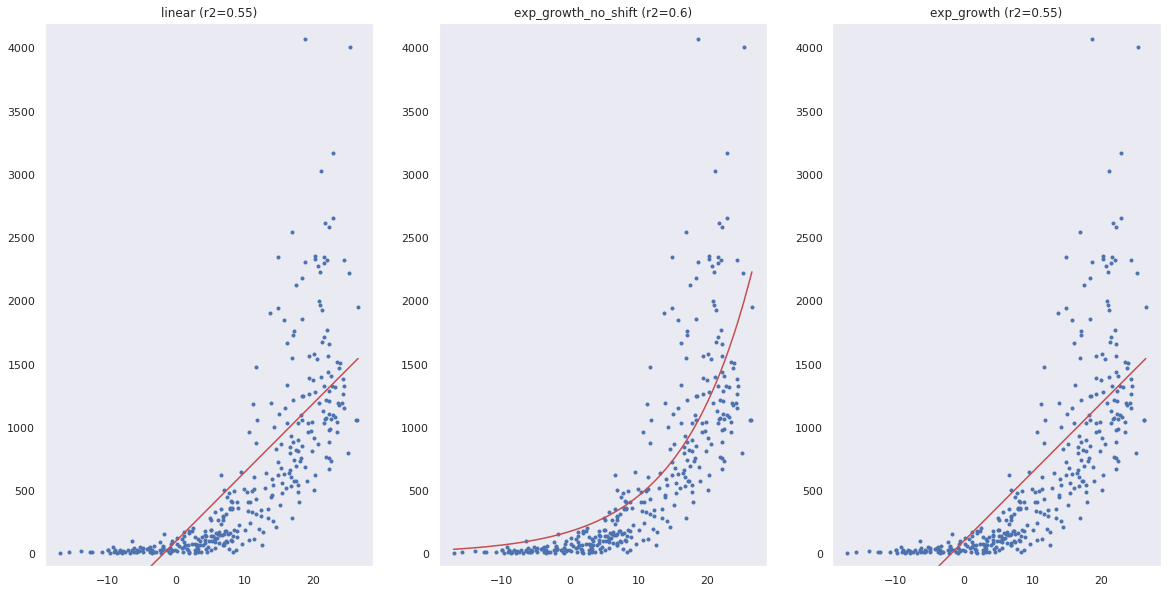

In [32]:
x = data['Mean Temp'].values
y = data['Casual Trips'].values

# Estimate curve for each of the method used and graph the fitted curve
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
for ax, func in zip(axes, [linear, exp_growth_no_shift, exp_growth]):
    popt, pcov = curve_fit(func, x, y, maxfev=2000)
    y_fit = func(x, *popt)
    
    r2 = 1 - (np.sum((y - y_fit) ** 2) / np.sum((y - np.mean(y)) ** 2))

    ax.plot(x, y, '.')
    ax.plot(x, y_fit, 'r-')
    ax.set_ylim(-100, 4200)
    ax.set_title('{0} (r2={1})'.format(func.__name__, np.round(r2, 2)))

plt.savefig('./visualization/fig_1.png')

In [33]:
popt, pcov = curve_fit(exp_growth_no_shift, x, y, maxfev=2000)

# Estimate the first knee point
kneedle = KneeLocator(x=x, y=exp_growth_no_shift(x, *popt), curve='convex', direction='increasing')
knee_start = kneedle.knee

print(knee_start)

16.1


In [32]:
def logistic_growth(x, k, x0):
    return 1 / (1 + np.exp(-k*(x - x0)))

In [33]:
data['Cummulative Trips'] = data['Casual Trips'].cumsum()
data['Percentage Trips'] = data['Cummulative Trips'] / data['Casual Trips'].sum()

In [34]:
x = data['Mean Temp'].values
y = data['Percentage Trips'].values

popt, pcov = curve_fit(logistic_growth, x, y, maxfev=2000)
y_fit = logistic_growth(x, *popt)

In [35]:
kneedle = KneeLocator(x=x, y=y_fit, curve='convex', direction='increasing')
knee_start = kneedle.knee

print(knee_start)

16.0


In [36]:
for idx, val in enumerate(x):
    if val > knee_start:
        kneedle = KneeLocator(x=x[idx:], y=y_fit[idx:], curve='concave', direction='increasing')
        knee_end = kneedle.knee
        
        print(knee_end)
        break

21.6
